# Verkehrsfluss

Die Stadt New York teilt ausführliche Verkehrsinformationen
[hier](https://data.cityofnewyork.us/Transportation/Real-Time-Traffic-Speed-Data/qkm5-nuaq)
und eine Erklärung der Daten befindet sich
[hier](https://data.cityofnewyork.us/api/views/i4gi-tjb9/files/cc7f3b15-58b7-46e3-94e7-4c5753c3a8b8?download=false&filename=metadata_trafficspeeds.pdf).
Diese Verkehrsdaten möchten wir dahingehend untersuchen, ob sich für bestimmte Straßenabschnitte wiederkehrende Muster ergeben.

In [1]:
# Die folgenden Pakete sind nicht Teil der Standard-Conda-Umgebung.
# Beim ersten Ausführen des Jupyter Notebooks müssen Sie diese also zusätzlich installieren. Falls sie eines der Pakete
# installieren wollen, entfernen Sie die Raute und führen die Zelle aus. Fügen Sie am besten danach die Raute
# sicherheitshalber wieder hinzu, damit beim nächsten Ausführen dieser Zelle nicht erneut versucht wird, die Bibliothek
# zu installieren.

# %pip install sodapy

# Innerhalb einer Conda-Umgebung ist conda install gegenüber pip install zu bevorzugen
# %conda install -c conda-forge folium
# %pip install folium

In [2]:
import os

import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

from sodapy import Socrata

pd.options.display.max_rows = 10  # zeige maximal 10 Einträge eines DataFrames an

Als Erstes werden die Positionen der Streckenabschnitte geladen.
Allerdings bremst die Stadt New York, wenn es zu viele Anfragen gleichzeitig gibt.
Sollte der Prozess zu lange dauern, benötigen Sie einen sogenannten App Token zur Identifikation, der
[hier](https://dev.socrata.com/docs/app-tokens.html)
beantragt werden kann.

Falls Sie einen App Token erhalten haben, schreiben Sie diesen anstelle des `None` in folgender Zeile:

In [3]:
app_token = None  # <-- hier den Wert händisch eintragen oder einfach auf None stehen lassen

if app_token is None and os.path.isfile(".app_token.txt"):
    with open(".app_token.txt") as f:
        app_token = f.read().strip()

print("App Token: ", app_token)

App Token:  2zrLg3S9zgX7PwE8PzJ45mWgs


Nun können wir den Client initialisieren.

In [4]:
NAME_OF_DATASET = "i4gi-tjb9"

client = Socrata(
    "data.cityofnewyork.us",
    app_token,
    timeout=60
)

Zunächst laden wir die Meta-Daten herunter.

In [5]:
metadata = client.get_metadata(NAME_OF_DATASET)

metadata

{'id': 'i4gi-tjb9',
 'name': 'DOT Traffic Speeds NBE',
 'assetType': 'dataset',
 'averageRating': 0,
 'category': 'Transportation',
 'createdAt': 1492453864,
 'displayType': 'table',
 'downloadCount': 3412,
 'hideFromCatalog': True,
 'hideFromDataJson': False,
 'indexUpdatedAt': 1536607953,
 'newBackend': True,
 'numberOfComments': 0,
 'oid': 25806010,
 'provenance': 'official',
 'publicationAppendEnabled': False,
 'publicationDate': 1493316328,
 'publicationGroup': 14152591,
 'publicationStage': 'published',
 'rowClass': '',
 'rowsUpdatedAt': 1644587143,
 'rowsUpdatedBy': '5fuc-pqz2',
 'tableId': 14152591,
 'totalTimesRated': 0,
 'viewCount': 11534,
 'viewLastModified': 1581122414,
 'viewType': 'tabular',
 'approvals': [{'reviewedAt': 1499908472,
   'reviewedAutomatically': True,
   'state': 'approved',
   'submissionId': 1067550,
   'submissionObject': 'public_audience_request',
   'submissionOutcome': 'change_audience',
   'submittedAt': 1499908472,
   'workflowId': 2285,
   'submis

Hiermit wird nun die PDF mit den weiterführenden Informationen heruntergeladen.
Der Pfad befindet sich in der Ausgabe.

In [6]:
client.download_attachments(
    NAME_OF_DATASET,
    content_type="json",
    download_dir="."
)

['.\\i4gi-tjb9\\metadata_trafficspeeds.pdf']

Nun können wir uns die ersten 5000 Datenpunkte anschauen.

In [7]:
results = client.get(NAME_OF_DATASET, limit=5000)

results

[{'id': '295',
  'speed': '62.13',
  'travel_time': '71',
  'status': '0',
  'data_as_of': '2022-02-11T06:38:04.000',
  'link_id': '4616250',
  'link_points': '40.84064,-73.83831 40.83881,-73.83853 40.8346304,-73.83839 40.83261,-73.83804 40.83066,-73.837521 40.8280704,-73.83668 40.82495,-73.836211',
  'encoded_poly_line': '_ugxFlptaMlJj@bY[rKeAdKgBdOgDnR}A',
  'encoded_poly_line_lvls': 'BBBBBBB',
  'owner': 'NYC_DOT_LIC',
  'transcom_id': '4616250',
  'borough': 'Bronx',
  'link_name': 'HRP N LAFAYETTE AVENUE - E TREMONT AVENUE'},
 {'id': '165',
  'speed': '52.19',
  'travel_time': '55',
  'status': '0',
  'data_as_of': '2022-02-11T06:38:04.000',
  'link_id': '4616305',
  'link_points': '40.81477,-73.83629 40.81611,-73.83627 40.8178404,-73.83601 40.8202405,-73.83589 40.823961,-73.83607 40.82513,-73.83624',
  'encoded_poly_line': 'isbxFxctaMkGCyIs@_NWgVb@iF`@',
  'encoded_poly_line_lvls': 'BBBBBB',
  'owner': 'NYC_DOT_LIC',
  'transcom_id': '4616305',
  'borough': 'Bronx',
  'link_name'

Wir setzen fest, dass wir die letzten 5000 Datenpunkte erhalten wollen.

In [8]:
df = pd.DataFrame.from_records(results)
df.head()

,id,speed,travel_time,status,data_as_of,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,owner,transcom_id,borough,link_name
0,295,62.13,71,0,2022-02-11T06:38:04.000,4616250,"40.84064,-73.83831 40.83881,-73.83853 40.83463...",_ugxFlptaMlJj@bY[rKeAdKgBdOgDnR}A,BBBBBBB,NYC_DOT_LIC,4616250,Bronx,HRP N LAFAYETTE AVENUE - E TREMONT AVENUE
1,165,52.19,55,0,2022-02-11T06:38:04.000,4616305,"40.81477,-73.83629 40.81611,-73.83627 40.81784...",isbxFxctaMkGCyIs@_NWgVb@iF`@,BBBBBB,NYC_DOT_LIC,4616305,Bronx,BWB N Toll Plaza - HRP N Lafayatte Ave
2,423,45.36,118,0,2022-02-11T06:38:04.000,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@\\|@Yr@MdAGhA@dH\~@E\\|@GbMo...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616299,Queens,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...
3,332,22.36,412,0,2022-02-11T06:38:04.000,4616354,"40.683644,-73.72667001 40.68314,-73.72692 40...",w_iwFtv~`MbBp@bJbFbN`JlC~BhJtJfFrEdHvFtDhCnW~O...,BBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616354,Queens,Laurelton Pkwy S @ SSP - Belt Pkwy W 182nd St
4,425,47.84,225,0,2022-02-11T06:38:04.000,4616276,"40.67445,-73.80181 40.67374,-73.80154 40.67261...",ifgwFhlmaMlCu@`Fo@dJMrSp@`PfDnCd@pCk@\\|B_D^}D...,BBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616276,Queens,VWE S MP2.66 (Exit 2 Rockaway Blvd) - Belt Pkw...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      5000 non-null   object
 1   speed                   5000 non-null   object
 2   travel_time             5000 non-null   object
 3   status                  5000 non-null   object
 4   data_as_of              5000 non-null   object
 5   link_id                 5000 non-null   object
 6   link_points             5000 non-null   object
 7   encoded_poly_line       5000 non-null   object
 8   encoded_poly_line_lvls  5000 non-null   object
 9   owner                   5000 non-null   object
 10  transcom_id             5000 non-null   object
 11  borough                 5000 non-null   object
 12  link_name               5000 non-null   object
dtypes: object(13)
memory usage: 507.9+ KB


In diesem Kontext heißt `object`, dass nur Zeichenketten vorliegen.
`data_as_of` ist dem Namen nach aber keine Zeichenkette, sondern ein Datum.
Somit ist die Repräsentation hier noch nicht ganz optimal.

In [10]:
df = df.assign(data_as_of__as_date=df["data_as_of"].astype('datetime64[ns]'))
df.head()

,id,speed,travel_time,status,data_as_of,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,owner,transcom_id,borough,link_name,data_as_of__as_date
0,295,62.13,71,0,2022-02-11T06:38:04.000,4616250,"40.84064,-73.83831 40.83881,-73.83853 40.83463...",_ugxFlptaMlJj@bY[rKeAdKgBdOgDnR}A,BBBBBBB,NYC_DOT_LIC,4616250,Bronx,HRP N LAFAYETTE AVENUE - E TREMONT AVENUE,2022-02-11 06:38:04
1,165,52.19,55,0,2022-02-11T06:38:04.000,4616305,"40.81477,-73.83629 40.81611,-73.83627 40.81784...",isbxFxctaMkGCyIs@_NWgVb@iF`@,BBBBBB,NYC_DOT_LIC,4616305,Bronx,BWB N Toll Plaza - HRP N Lafayatte Ave,2022-02-11 06:38:04
2,423,45.36,118,0,2022-02-11T06:38:04.000,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@\\|@Yr@MdAGhA@dH\~@E\\|@GbMo...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616299,Queens,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,2022-02-11 06:38:04
3,332,22.36,412,0,2022-02-11T06:38:04.000,4616354,"40.683644,-73.72667001 40.68314,-73.72692 40...",w_iwFtv~`MbBp@bJbFbN`JlC~BhJtJfFrEdHvFtDhCnW~O...,BBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616354,Queens,Laurelton Pkwy S @ SSP - Belt Pkwy W 182nd St,2022-02-11 06:38:04
4,425,47.84,225,0,2022-02-11T06:38:04.000,4616276,"40.67445,-73.80181 40.67374,-73.80154 40.67261...",ifgwFhlmaMlCu@`Fo@dJMrSp@`PfDnCd@pCk@\\|B_D^}D...,BBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616276,Queens,VWE S MP2.66 (Exit 2 Rockaway Blvd) - Belt Pkw...,2022-02-11 06:38:04


Das Attribut `link_id` steht für die Station.
Nun wollen wir erst einmal nur eine Station betrachten, und zwar die mit der link_id `4616215`.
Der Aufruf `df.info()` hat als eine Zeile `link_id 5000 non-null object` zurückgegeben.
Der Begriff `object` steht hier für Text, d. h. wir arbeiten nicht mit Zahlen, sondern Zeichenketten.
Deswegen muss der Wert in Anführungszeichen stehen.

In [11]:
examined_link_id = "4616215"

df_specific_link_id = df[df.link_id == examined_link_id]
df_specific_link_id.head()

,id,speed,travel_time,status,data_as_of,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,owner,transcom_id,borough,link_name,data_as_of__as_date
60,433,29.82,253,0,2022-02-11T06:37:13.000,4616215,"40.52561,-74.23039 40.5258705,-74.22618 40.526...",adjvF\\|badMs@iYaBsPcEB_\\|@vDyLWeHg@mUeF}L}EuIaF,BBBBBBBBBB,NYC_DOT_LIC,4616215,Staten Island,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,2022-02-11 06:37:13
194,433,52.19,143,0,2022-02-11T06:33:12.000,4616215,"40.52561,-74.23039 40.5258705,-74.22618 40.526...",adjvF\\|badMs@iYaBsPcEB_\\|@vDyLWeHg@mUeF}L}EuIaF,BBBBBBBBBB,NYC_DOT_LIC,4616215,Staten Island,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,2022-02-11 06:33:12
288,433,44.11,170,0,2022-02-11T06:27:12.000,4616215,"40.52561,-74.23039 40.5258705,-74.22618 40.526...",adjvF\\|badMs@iYaBsPcEB_\\|@vDyLWeHg@mUeF}L}EuIaF,BBBBBBBBBB,NYC_DOT_LIC,4616215,Staten Island,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,2022-02-11 06:27:12
456,433,34.79,216,0,2022-02-11T06:23:13.000,4616215,"40.52561,-74.23039 40.5258705,-74.22618 40.526...",adjvF\\|badMs@iYaBsPcEB_\\|@vDyLWeHg@mUeF}L}EuIaF,BBBBBBBBBB,NYC_DOT_LIC,4616215,Staten Island,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,2022-02-11 06:23:13
581,433,14.91,494,-101,2022-02-11T06:17:12.000,4616215,"40.52561,-74.23039 40.5258705,-74.22618 40.526...",adjvF\\|badMs@iYaBsPcEB_\\|@vDyLWeHg@mUeF}L}EuIaF,BBBBBBBBBB,NYC_DOT_LIC,4616215,Staten Island,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,2022-02-11 06:17:12


In [12]:
df_specific_link_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 60 to 4950
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      40 non-null     object        
 1   speed                   40 non-null     object        
 2   travel_time             40 non-null     object        
 3   status                  40 non-null     object        
 4   data_as_of              40 non-null     object        
 5   link_id                 40 non-null     object        
 6   link_points             40 non-null     object        
 7   encoded_poly_line       40 non-null     object        
 8   encoded_poly_line_lvls  40 non-null     object        
 9   owner                   40 non-null     object        
 10  transcom_id             40 non-null     object        
 11  borough                 40 non-null     object        
 12  link_name               40 non-null     object   

## Visualisierung der betrachteten Strecke

Zunächst visualisieren wir uns eine spezifische Strecke, die ausgewertet wird.
Dafür wird der Text aus der Tabelle in eine Liste von Listen von Gradzahlen umgerechnet.
`latlon` steht hier für Latitude-Longitude (Längengrad-Breitengrad) Koordinaten.

In [13]:
latlons = []
coordinate_text = df_specific_link_id.iloc[0]["link_points"]
print("Coordinate text:", coordinate_text)
for latlon in coordinate_text.split(" "):
    lat, lon = latlon.split(",")
    lat, lon = float(lat), float(lon)
    latlons.append((lat, lon))

latlons

Coordinate text: 40.52561,-74.23039 40.5258705,-74.22618 40.5263604,-74.22336 40.52734,-74.22338 40.5371,-74.2243 40.53931,-74.22418 40.5407805,-74.223981 40.54437,-74.22283 40.5466005,-74.22172 40.54831,-74.22059


[(40.52561, -74.23039),
 (40.5258705, -74.22618),
 (40.5263604, -74.22336),
 (40.52734, -74.22338),
 (40.5371, -74.2243),
 (40.53931, -74.22418),
 (40.5407805, -74.223981),
 (40.54437, -74.22283),
 (40.5466005, -74.22172),
 (40.54831, -74.22059)]

Diese kann man nun auf einer Karte darstellen.
Dafür bietet sich `folium` an.

In [14]:
import folium

m = folium.Map(latlons[0], zoom_start=11)
folium.features.PolyLine(latlons, weight=8).add_to(m)
display(m)

### Bereinigen der Daten

Häufig kommt es bei solchen CSV-Dateien zu Sprüngen, also das Einträge nicht streng der zeitlichen Reihenfolge nach sortiert sind.
Dies ist häufig mit Problemen in den technischen Systemen erklärbar.
Ob diese Schritte notwendig sind, hängt von der `link_id` ab!

In [15]:
print("is monotonic increasing: ", df_specific_link_id.index.is_monotonic_increasing)

is monotonic increasing:  True


In [16]:
# Zum Sortieren, falls obiger Code 'False' ausgibt
df_specific_link_id = df_specific_link_id.sort_index()
print("is monotonic increasing: ", df_specific_link_id.index.is_monotonic_increasing)

is monotonic increasing:  True


Nun stellt sich die Frage, wie häufig die Daten übermittelt werden.
Mit folgendem Trick bekommt man eine Übersicht:

### Attribut speed

Im Folgenden werden die Werte geplottet, um einen visuellen Eindruck zu erhalten.

In [17]:
speed_series = df_specific_link_id.set_index("data_as_of__as_date").speed.astype("float")
speed_series

data_as_of__as_date
2022-02-11 06:37:13    29.82
2022-02-11 06:33:12    52.19
2022-02-11 06:27:12    44.11
2022-02-11 06:23:13    34.79
2022-02-11 06:17:12    14.91
                       ...  
2022-02-11 02:58:11    43.49
2022-02-11 02:53:11     0.00
2022-02-11 02:48:11     0.00
2022-02-11 02:43:11     0.00
2022-02-11 02:38:11     0.00
Name: speed, Length: 40, dtype: float64

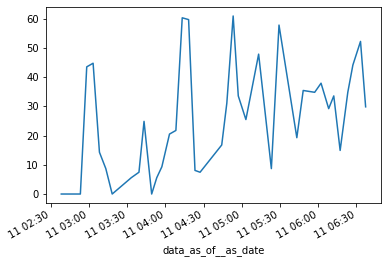

In [18]:
speed_series.plot(style="-")
plt.show()

# Prognose

Damit wir nun den Verkehr über einen längeren Zeitraum betrachten können, werden wir uns auf einen Knoten beschränken und dort erneut Daten der Stadt New York über die API anfragen.
Eine einfache Dokumentation lässt sich wie immer über den Fragezeichen-Operator abfragen.

In [19]:
?Socrata.get

Signature: Socrata.get(self, dataset_identifier, content_type='json', **kwargs)
Docstring:
Read data from the requested resource. Options for content_type are json,
csv, and xml. Optionally, specify a keyword arg to filter results:

    select : the set of columns to be returned, defaults to *
    where : filters the rows to be returned, defaults to limit
    order : specifies the order of results
    group : column to group results on
    limit : max number of results to return, defaults to 1000
    offset : offset, used for paging. Defaults to 0
    q : performs a full text search for a value
    query : full SoQL query string, all as one parameter
    exclude_system_fields : defaults to true. If set to false, the
        response will include system fields (:id, :created_at, and
        :updated_at)

More information about the SoQL parameters can be found at the official
docs:
    http://dev.socrata.com/docs/queries.html

More information about system fields can be found here:
    h

Nun möchten wir die abgerufenen Informationen von Vornherein auf das Wesentliche beschränken.

In [20]:
results = client.get(
    NAME_OF_DATASET,
    select="data_as_of, speed",
    where=f"link_id = '{examined_link_id}' AND data_as_of >= '2021-12-01'",
    limit=(12 * 24 * 30 * 3)
)

results

[{'data_as_of': '2021-12-02T23:04:11.000', 'speed': '52.19'},
 {'data_as_of': '2021-12-03T07:29:11.000', 'speed': '51.57'},
 {'data_as_of': '2021-12-03T10:59:10.000', 'speed': '50.33'},
 {'data_as_of': '2021-12-03T09:58:11.000', 'speed': '50.95'},
 {'data_as_of': '2021-12-03T11:43:11.000', 'speed': '52.19'},
 {'data_as_of': '2021-12-03T11:53:11.000', 'speed': '49.70'},
 {'data_as_of': '2021-12-03T12:18:10.000', 'speed': '51.57'},
 {'data_as_of': '2021-12-03T12:34:11.000', 'speed': '54.05'},
 {'data_as_of': '2021-12-03T13:59:10.000', 'speed': '53.43'},
 {'data_as_of': '2021-12-03T15:24:10.000', 'speed': '54.05'},
 {'data_as_of': '2021-12-03T16:49:11.000', 'speed': '47.84'},
 {'data_as_of': '2021-12-03T15:44:11.000', 'speed': '52.19'},
 {'data_as_of': '2021-12-03T21:13:11.000', 'speed': '51.57'},
 {'data_as_of': '2021-12-29T10:59:13.000', 'speed': '51.57'},
 {'data_as_of': '2021-12-03T19:53:11.000', 'speed': '50.33'},
 {'data_as_of': '2021-12-04T07:02:10.000', 'speed': '58.40'},
 {'data_

In [21]:
df = pd.DataFrame.from_records(results)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17279 entries, 0 to 17278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data_as_of  17279 non-null  object
 1   speed       17279 non-null  object
dtypes: object(2)
memory usage: 270.1+ KB


,data_as_of,speed
0,2021-12-02T23:04:11.000,52.19
1,2021-12-03T07:29:11.000,51.57
2,2021-12-03T10:59:10.000,50.33
3,2021-12-03T09:58:11.000,50.95
4,2021-12-03T11:43:11.000,52.19


Für eine Weiterverarbeitung sollte nun der Text in die passende Einheit umgewandelt werden, sprich in ein Datum oder in eine Fließkommazahl.

In [22]:
df["data_as_of"] = df["data_as_of"].astype('datetime64[ns]')
df["speed"] = df["speed"].astype('float')
df.set_index("data_as_of", inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17279 entries, 2021-12-02 23:04:11 to 2022-02-11 06:37:13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   17279 non-null  float64
dtypes: float64(1)
memory usage: 270.0 KB


,speed
data_as_of,
2021-12-02 23:04:11,52.19
2021-12-03 07:29:11,51.57
2021-12-03 10:59:10,50.33
2021-12-03 09:58:11,50.95
2021-12-03 11:43:11,52.19


Auch hier kann es wieder sein, dass die Reihenfolge der Daten nicht stimmt.
Manche Funktionen von pandas funktionieren dann nicht.
Deswegen sortieren wir die Daten vor.

In [23]:
print("is monotonic increasing: ", df.index.is_monotonic_increasing)
df = df.sort_index()
print("is monotonic increasing: ", df.index.is_monotonic_increasing)

is monotonic increasing:  False
is monotonic increasing:  True


Nun wollen wir die Geschwindigkeit von gestern betrachten.

In [24]:
import datetime

today = datetime.datetime.now()

yesterday = today - datetime.timedelta(days=1)

yesterday_as_date = yesterday.date()

yesterday_as_date.isoformat()

'2022-02-10'

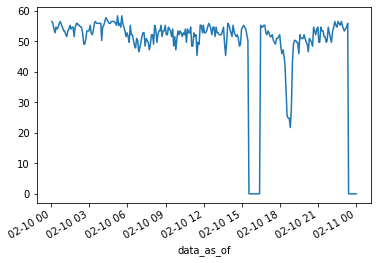

In [25]:
df.speed[yesterday_as_date.isoformat()].plot()
plt.show()

# Weiterführende Auswertungen

Für sich wiederholende Muster gibt es verschiedene Möglichkeiten, diese zu visualisieren.
Jede Methode hat ihre eigenen Stärken und Schwächen.

In [26]:
df = df.loc["2021-11":"2021-12"]
df

,speed
data_as_of,
2021-12-01 00:03:10,54.05
2021-12-01 00:09:10,54.05
2021-12-01 00:13:10,55.30
2021-12-01 00:24:10,54.68
2021-12-01 00:29:10,55.92
...,...
2021-12-31 23:39:12,57.78
2021-12-31 23:44:13,58.40
2021-12-31 23:49:12,58.40


## Plots mit Gruppierung

Anstelle der strikten zeitlichen Abfolge können Plots auch anhand verschiedener anderer Kriterien gruppiert und dann ausgewertet werden.
Dies geschieht in pandas mit der Methode `groupby`.

Nun wird die durchschnittliche Geschwindigkeit für jede Stunde des Tages geplottet, also von 00:00 bis 23:00.

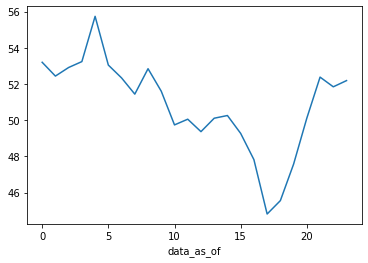

In [27]:
def extract_hour(pandas_timestamp):
    return pandas_timestamp.hour


hourly_speed_mean = df.speed.groupby(extract_hour).agg('mean')
hourly_speed_mean.plot()
plt.show()

(a) Interpretieren Sie den Plot

Nun wird die Standardabweichung dargestellt.
(b) Wie kann man diese nun interpretieren?

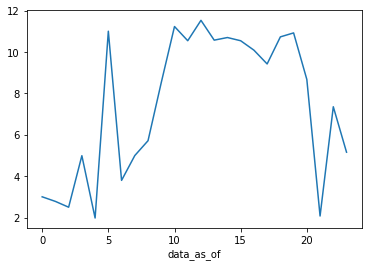

In [28]:
hourly_speed_std = df.speed.groupby(extract_hour).agg('std')
hourly_speed_std.plot()
plt.show()

## Autokorrelation

Die Autokorrelation gibt Aufschluss über sich wiederholende Muster.
Wie genau kann man die Abbildung interpretieren?
Wie vielen Minuten entspricht der Lag von 1? 
Wie groß ist die erwartete Zeitspanne für die Autokorrelation? 
Wie groß ist in diesem Beispiel der Lag, den man aus der Alltagserfahrung heraus erwarten würde?

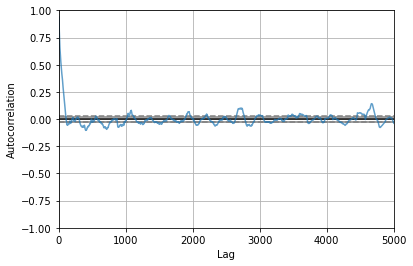

In [29]:
autocorrelation_plot(df.speed, alpha=0.7)
plt.xlim([0, 5000])  # Begrenze Plot auf die ersten 5000 Einträge
plt.show()

## Prognose der zweiten Monatshälfte anhand der ersten

Wie lässt sich die zweite Monatshälfte mithilfe der ersten Monatshälfte vorhersagen?
Vermutlich lassen sich hier die Prinzipien des vorherigen Notebooks zum Thema Gezeiten anwenden.

In [30]:
n = len(df)
df_train, df_test = df.iloc[:(n // 2)], df.iloc[(n // 2):]
df_train.info()
df_test.info()
df_train

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3440 entries, 2021-12-01 00:03:10 to 2021-12-13 12:13:11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   3440 non-null   float64
dtypes: float64(1)
memory usage: 53.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3440 entries, 2021-12-13 12:17:11 to 2021-12-31 23:59:13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   3440 non-null   float64
dtypes: float64(1)
memory usage: 53.8 KB


,speed
data_as_of,
2021-12-01 00:03:10,54.05
2021-12-01 00:09:10,54.05
2021-12-01 00:13:10,55.30
2021-12-01 00:24:10,54.68
2021-12-01 00:29:10,55.92
...,...
2021-12-13 11:54:11,51.57
2021-12-13 11:57:12,49.70
2021-12-13 12:04:11,54.05


### Mittelwert als Baseline

Eine sehr einfache Annahme ist, dass ein Zufallsprozess vorliegt, der der Gauß'schen Normalverteilung folgt.
Alle Ausschläge werden somit als zufällig angesehen.
Für Normalverteilungen ist der Mittelwert ein guter Schätzer ist.

In [31]:
mean_of_train = df_train.speed.mean()
average_as_estimator = (mean_of_train - df_test.speed)
rmse_with_average = (average_as_estimator ** 2).mean() ** .5
mean_of_train, rmse_with_average

(50.947174418604654, 10.186553817471534)

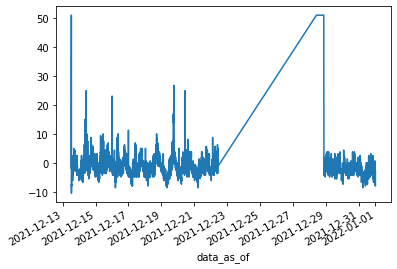

In [32]:
average_as_estimator.plot()
plt.show()

Jedes Verfahren, das auch nur etwas komplexer als die Mittelwertberechnung ist und dabei höhere Fehler produziert, sollte nur dann verwendet werden, wenn es dafür sehr gute Gründe gibt.
Allgemein gilt, das einfache Mittel bevorzugt werden sollen.

### Naiver Schätzer


Der nun vorgestellte naive Schätzer funktioniert vergleichbar mit dem naiven Schätzer der Gezeiten in Abschnitt 1.4.2, es wird wieder nur ein Wert aus der Vergangenhet genommen um die Zukunft vorherzusagen. Diesmal liegt jedoch nicht für jeden Zeitpunkt ein Eintrag vor.
Deswegen wird eine Hilfsmethode verwendet, die den nächstgelegenen Eintrag zurückgibt.
Bei den Gezeiten haben wir einen Zyklus von 12h und 25Minuten gewählt. Wie lange ist ein Zyklus in diesem Fall?

(a) Tragen Sie einen Wert ein, der sich aus der Domäne heraus rechtfertigen lässt und begründen Sie Ihre Entscheidung.

In [33]:
from traffic_time_series_utils import get_nearest_entry

zyklus_laenge_in_stunden = 1  # Hier müssen Sie die Zykluslänge eintragen


def naive_estimator(this_series, t):
    if t < first_day:
        print("Nur für Prognose, nicht in die Vergangenheit")
        return
    nearest_entry = get_nearest_entry(this_series, t)
    if nearest_entry is not None:
        return nearest_entry  # Gebe tatsächlichen Wert zurück
    else:
        t = t - pd.Timedelta(hours=zyklus_laenge_in_stunden)  # Betrachte Wert des vorherigen Zyklus
        return naive_estimator(this_series, t)

Definieren Sie `first_day` und `last_day` anhand des DataFrames `df_train`, wie es bereits bei den Gezeiten vorgenommen worden ist.

(b) Wie bekommen Sie das Datum des ersten Eintrages von df_train?

(c) Wie bekommen Sie das Datum des letzten Eintrages von df_train?

In [34]:
first_day = ...  # Tragen Sie hier den ersten Tag ein
last_day = ...  # Tragen Sie hier den letzten Tag ein

first_day, last_day

(Ellipsis, Ellipsis)

(d) Benutzen Sie nun die Schätzfunktion, um für die zweite Hälfte des Monats den Verkehr zu schätzen.
Hier lohnt sich ebenfalls der Blick in das vorherige Notebook.

In [35]:
estimated = ...
estimated_as_series = ...
estimated_as_series

Ellipsis

Plotten Sie nun das Ergebnis der Schätzung gemeinsam mit den tatsächlichen Daten:

In [ ]:
estimated_as_series.plot()
df_test.speed.plot()
plt.show()

(e) Plotten Sie nun den Fehler und ermitteln Sie die Fehler-Statistiken mittels `describe`.
Wird die Geschwindigkeit eher über- oder unterschätzt?

In [ ]:
# Ihr Code...

(f) Berechnen Sie den Durchschnitt und den RMSE und geben Sie diese an

In [ ]:
# Ihr Code...

(g) Ist nun der naive Schätzer oder der Durchschnitt der bessere Schätzer? Woran könnte dies es liegen? Begründen Sie.

In [ ]:
# Ihr Code...

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Lizenzvertrag" style="border-width:0; display:inline" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a> &nbsp;&nbsp;&nbsp;&nbsp;Dieses Werk von Marvin Kastner ist lizenziert unter einer <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Namensnennung 4.0 International Lizenz</a>.